In [8]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets, plotting, image
from nilearn.maskers import NiftiMapsMasker
from sklearn.decomposition import FastICA
import pandas as pd
import tarfile
import gzip
import math
from scipy.stats import t
from ast import literal_eval
import re

import stat_tests

# Exploratory Data Analysis

# Step 1. Find observed difference in male and female subjects

In [9]:
# load in data
data_file = 'Data/data_clean.csv.gz'

with gzip.open(data_file) as filepath:
    data = pd.read_csv(filepath, index_col = 'subject_id', 
            converters = {'netmat' : lambda x : np.array(literal_eval(re.sub('(?<!\[)\s+|[\\n]', ', ', x)))})
    
data.head()

,Gender,Age,netmat
subject_id,,,
100206,M,26-30,"[[0.0, 0.61676, 9.5727, -5.4959, 0.34639, 3.00..."
100307,F,26-30,"[[0.0, -0.29664, 17.317, -9.0467, -0.28723, 1...."
100408,M,31-35,"[[0.0, 1.6486, 6.6189, -8.8877, 1.4337, 1.006,..."
100610,M,26-30,"[[0.0, -0.90275, 7.7215, -8.3907, 3.3144, 2.93..."
101006,F,31-35,"[[0.0, -0.088768, 9.4979, -10.412, 1.0646, 4.3..."


In [10]:
sex = "Gender" # column name for male or female assignment
netmat = "netmat"

df = data[[sex, netmat]]

m = "M"
f = "F"
male_df = df[df[sex] == m] # get all males
female_df = df[df[sex] == f] # get all females

avg_netmat = df.groupby(sex).mean()[netmat] # find element-wise averages in male correlation matrix and female correlation matrix
m_avg_netmat = avg_netmat.loc[m]
f_avg_netmat = avg_netmat.loc[f]

diff_avg_netmat = m_avg_netmat - f_avg_netmat # find element-wise difference in averages between male and female correlation matrix (M - F)

## Aggregated Pairwise Correlation Matrices

In [11]:
num_males = male_df.shape[0]
num_females = female_df.shape[0]
print(f"Below are the correlation matrices found by performing element-wise averages on each unique pairwise correlation value \nfor all {num_males} males, and again for all {num_females} females.")

Below are the correlation matrices found by performing element-wise averages on each unique pairwise correlation value 
for all 469 males, and again for all 534 females.


In [12]:
# helpers
def set_upper_triangular(symmetric_matrix):
    '''returns only the upper triangular values of a symmetric matrix'''
    num_pairwise = symmetric_matrix.shape[0]
    no_diagonal = 1

    new_matrix = symmetric_matrix.copy()
    new_matrix[np.tril_indices(n=num_pairwise, k=no_diagonal)] = 0
    return new_matrix

def get_upper_triangular(symmetric_matrix):
    """
    Returns only the upper triangular values of a symmetric matrix
    """
    num_pairwise = symmetric_matrix.shape[0]
    no_diagonal = 1
    return symmetric_matrix[np.triu_indices(n=num_pairwise, k=no_diagonal)]

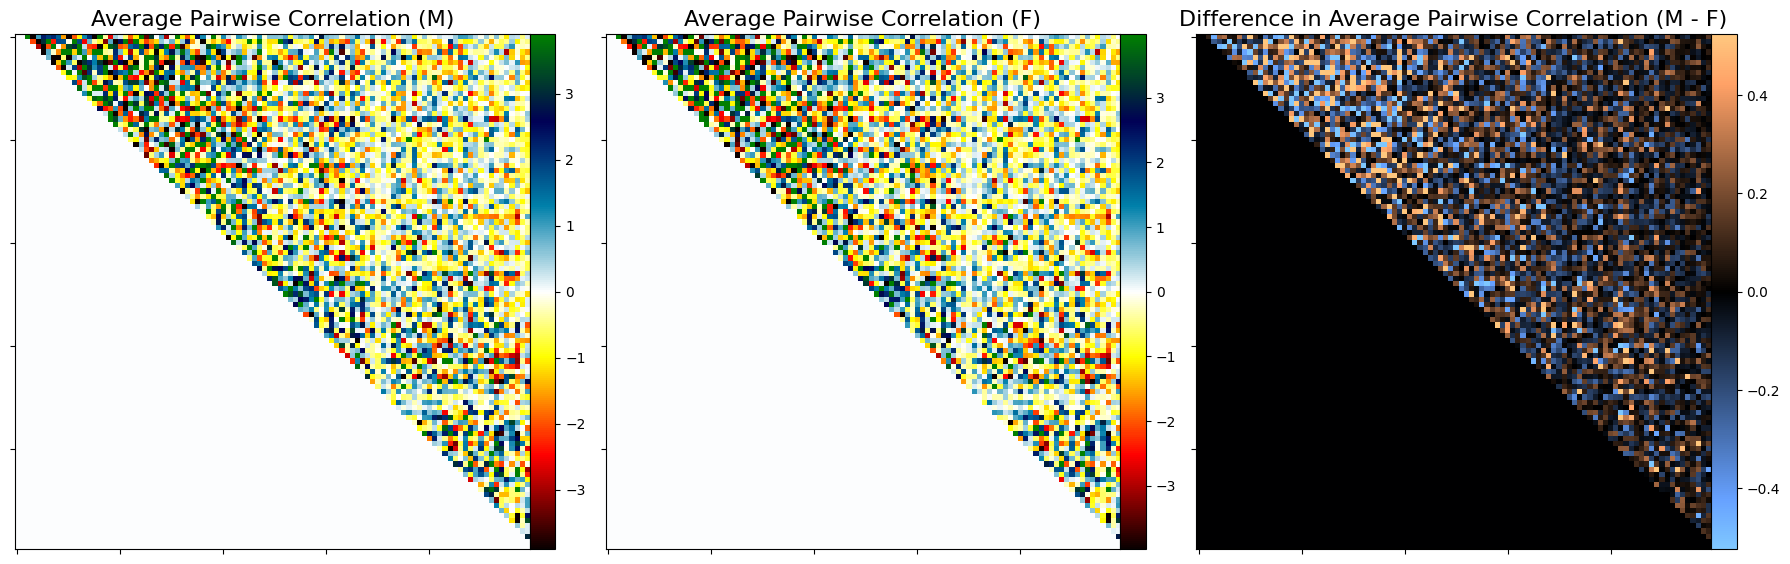

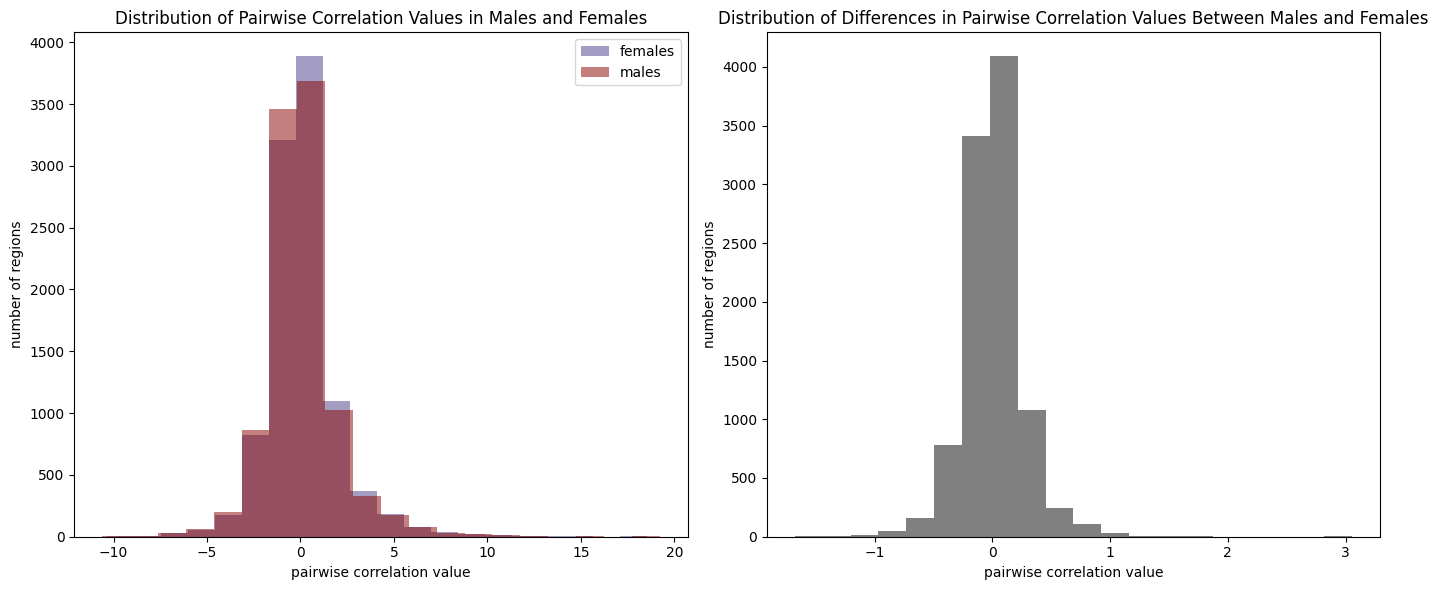

In [25]:
def get_minmax(netmats):
    span = max(np.abs(netmats.mean() - 2 * np.std(netmats)), np.abs(netmats.mean() + 2 * np.std(netmats)))
    return -span, span
m_avg_netmat_vmin, m_avg_netmat_vmax = get_minmax(m_avg_netmat)
f_avg_netmat_vmin, f_avg_netmat_vmax = get_minmax(f_avg_netmat)

cmap = 'ocean_hot_r'
bicmap  = 'cyan_copper'

# heatmaps
# m/f netmats
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plotting.plot_matrix( # visualize element-wise average of males
   set_upper_triangular(m_avg_netmat), colorbar=True, vmax=m_avg_netmat_vmax, vmin=m_avg_netmat_vmin, axes=axes[0], title = "Average Pairwise Correlation (M)", cmap=cmap)
plotting.plot_matrix( # visualize element-wise average of females
    set_upper_triangular(f_avg_netmat), colorbar=True, vmax=f_avg_netmat_vmax, vmin=f_avg_netmat_vmin, axes=axes[1], title = "Average Pairwise Correlation (F)", cmap=cmap)
diff_vmin, diff_vmax = get_minmax(diff_avg_netmat)
plotting.plot_matrix( # visualize element-wise difference of averages
    set_upper_triangular(diff_avg_netmat), colorbar=True, vmax=diff_vmax, vmin=diff_vmin, axes=axes[2], title = "Difference in Average Pairwise Correlation (M - F)", cmap=bicmap)
plt.tight_layout()


# histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
bins = 20
m_color = 'darkslateblue'
f_color = 'darkred'
# m/f netmats
ax1.hist(m_avg_netmat.flatten(), bins=bins, label="females", alpha=0.5, color=m_color)
ax1.hist(f_avg_netmat.flatten(), bins=bins, label="males", alpha=0.5, color=f_color)
ax1.set_xlabel('pairwise correlation value')
ax1.set_ylabel('number of regions')
ax1.set_title('Distribution of Pairwise Correlation Values in Males and Females')
ax1.legend()
# difference in magnitudes
ax2.hist(diff_avg_netmat.flatten(), bins=bins, color='grey')
ax2.set_xlabel('pairwise correlation value')
ax2.set_ylabel('number of regions')
ax2.set_title('Distribution of Differences in Pairwise Correlation Values Between Males and Females')

plt.tight_layout()

We are interested in whether there is a difference in male and female fMRI resting state data. In order to test this difference, we compare the pairwise correlation matrices of roughly 500 male subject and 500 female subjects. We aggregated the male subjects' and the female subjects' pairwise correlation matrices into a single matrix that contains the average correlation for each of the unique pairwise regions.  
  
To further explore the possible differences in male and female fMRI resting state data, we represented the averaged correlation matrices for each sex as a histogram and found that, to the naked eye, there are no visually obvious differences between male and female fMRI resting state data.  
  
However, we can conduct a more formal test that better quantifies whether the observed difference between male and female data is statistically significant.

# Step 2. Perform Statistical Tests

## I. Conducting a Two-Sided Independent Samples $t$-Test

### A. Check Assumptions

Here, we must check a few assumptions about our data before conducting a two-sample t-test.   
*note that we are using Welch's t-test, which does not assume that the two populations have the same variance**

1. Populations are independent of one another.
    - We know that male pairwise correlation matrices are independent from female pairwise correlation matrices.  
2. Populations are normally distributed.
    - The Fischer Transform of correlation values produces gaussian distributions for each pairwise region across all subjects in the respective sex.  
3. Data within each population are independent.
    - We know that the correlation matrices of same-sex subjects are independent from eahcother.
    

### B. Perform $t$-Test

Here, we conduct an two-sample t-test that quantifies whether the observed difference between male and female fMRI data is statistically significant.  
  
To conduct an two-sample t-test, we begin by defining a Null Hypothesis and Alternative Hypothesis:  
- Null Hypothesis ($H_0$): Male and female fMRI resting state data are not different.
    - The average correlation matrix of all males and the average correlation matrix of all females have a difference of 0.
    - $\mu_{Male} - \mu_{Female} = 0$
- Alternative Hypothesis ($H$): Male and female fMRI resting state data are different.
    - The average correlation matrix of all males and the average correlation matrix of all females do not have a difference of 0.
    - $\mu_{Male} - \mu_{Female} \neq 0$


In [14]:
male_netmats = male_df[netmat].to_numpy()
female_netmats = female_df[netmat].to_numpy()
t_stats, m_f_sqse, t_p_vals = stat_tests.get_tstats(male_netmats, female_netmats)

c:\Users\dfabe\Documents\GitHub\DSC180B-Capstone-ProjectA09\stat_tests.py:54: RuntimeWarning: invalid value encountered in divide
  t_stats = diff_means / overall_se


### C. Identify Statistically Significant Pairwise Correlations

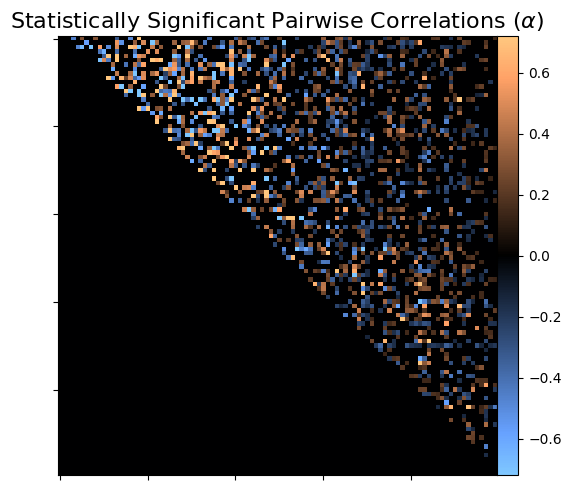

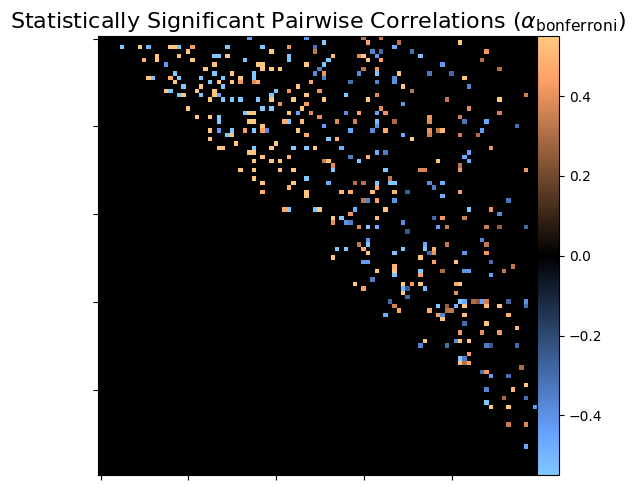

In [28]:
alpha = 0.01

num_regions = diff_avg_netmat.shape[0]
num_pairwise_regions = math.comb(num_regions, 2)
bonferroni_alpha = alpha / num_pairwise_regions # bonferroni correction

t_significant_regions = stat_tests.get_sig_regions(diff_avg_netmat, t_p_vals, alpha, title='Statistically Significant Pairwise Correlations ($\\alpha$)', cmap=bicmap)
t_significant_regions_bonferroni = stat_tests.get_sig_regions(diff_avg_netmat, t_p_vals, bonferroni_alpha, title='Statistically Significant Pairwise Correlations ($\\alpha_{\\text{bonferroni}}$)', cmap=bicmap)

In [16]:
print(f"Of the {num_pairwise_regions} pairwise correlations, {(t_significant_regions_bonferroni != 0).sum() / 2} are statistically significant under the alpha={bonferroni_alpha}.")
print(f"{(t_significant_regions != 0).sum() / 2} are statistically significant under the alpha={alpha}.")

Of the 4950 pairwise correlations, 427.0 are statistically significant under the alpha=2.02020202020202e-06.
1695.0 are statistically significant under the alpha=0.01.


In [17]:
bonferroni_significant_edges = np.where(t_significant_regions_bonferroni == 0, 0, True)
significant_edges = np.where(t_significant_regions == 0, 0, True)
np.savetxt("bonferroni_sig_edges.csv", bonferroni_significant_edges, delimiter=",")
np.savetxt("significant_edges.csv", significant_edges, delimiter=",")

## Step 3. Exploratory Values

Of all unique pairwise regions, what proportion of them have statistically significant differences in correlation between males and females?

In [18]:
1 - (get_upper_triangular(t_significant_regions_bonferroni) == 0).mean() # proportion of all pairwise regions that have statistically significant difference

0.08626262626262626

How much of the overall difference between males and females is attributable to the pairwise regions with statistically significant differences in correlation between males and females?

In [19]:
np.linalg.norm(t_significant_regions_bonferroni) / np.linalg.norm(diff_avg_netmat) # proportion of the overall difference attributable to significant regions


0.7135527629984316

## Pairwise Regions with Statistically Significant Different Correlation Values Between Males and Females

In [155]:
# get average values at significant pairwise regions for males and females
m_significant_regions_bonferroni = np.where(t_significant_regions_bonferroni == 0, 0, m_avg_netmat) # heatmap matrix (non-significant pairwise regions have pcorr = 0)
f_significant_regions_bonferroni = np.where(t_significant_regions_bonferroni == 0, 0, f_avg_netmat)
m_sig_corr_bonferroni = m_significant_regions_bonferroni[~(m_significant_regions_bonferroni == 0)] # correlations only 
f_sig_corr_bonferroni = f_significant_regions_bonferroni[~(f_significant_regions_bonferroni == 0)]

# get average values at bonferroni significant pairwise regions for males and females
m_significant_regions = np.where(t_significant_regions == 0, 0, m_avg_netmat) # heatmap matrix (non-significant pairwise regions have pcorr = 0)
f_significant_regions = np.where(t_significant_regions == 0, 0, f_avg_netmat)
m_sig_corr = m_significant_regions[~(m_significant_regions == 0)] # correlations only 
f_sig_corr = f_significant_regions[~(f_significant_regions == 0)]

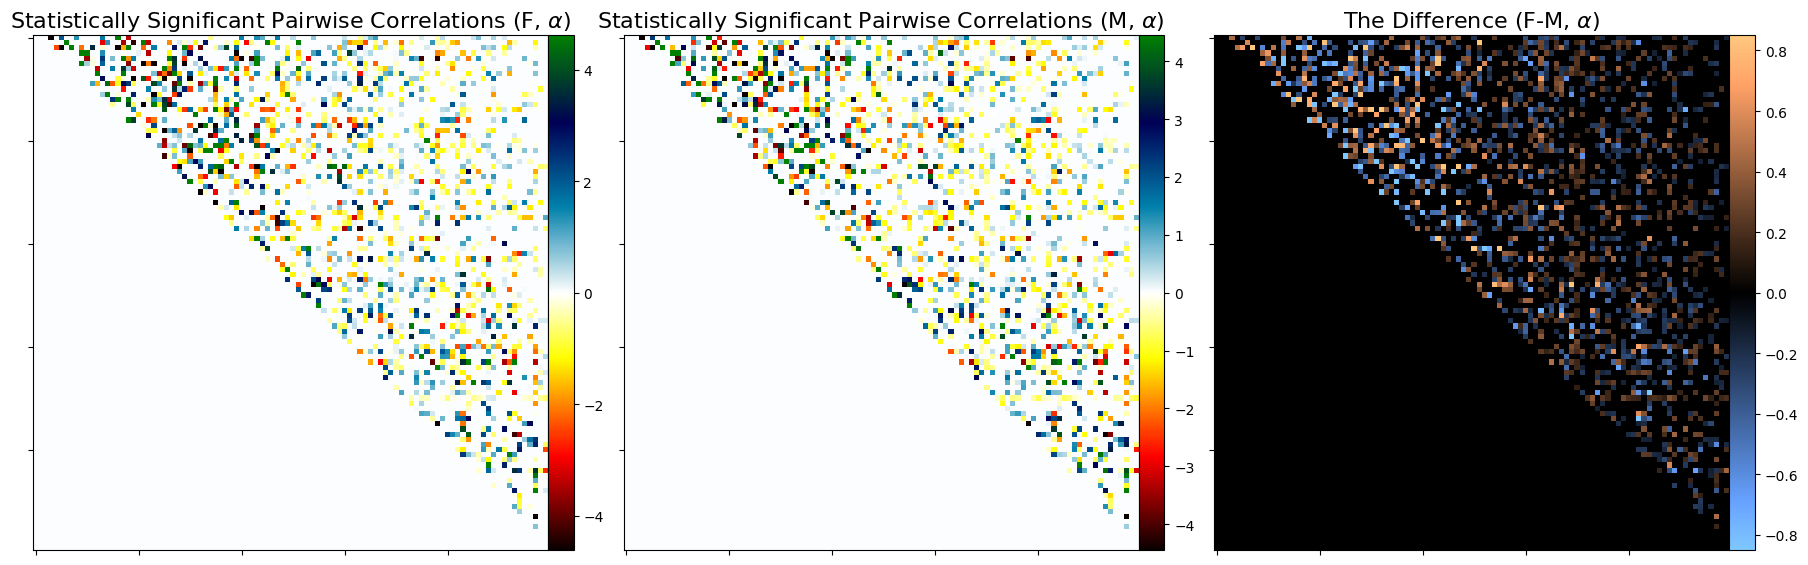

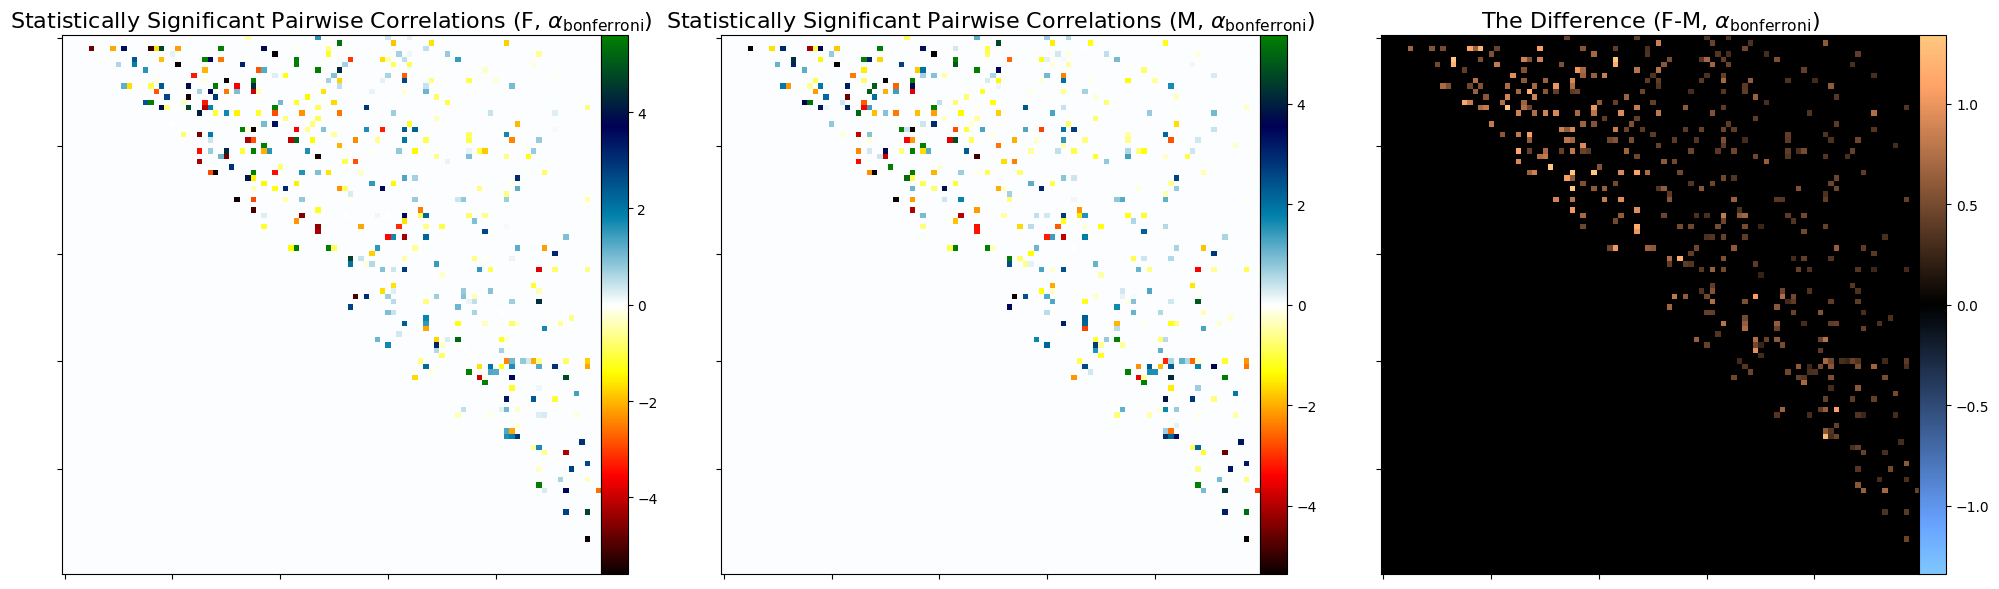

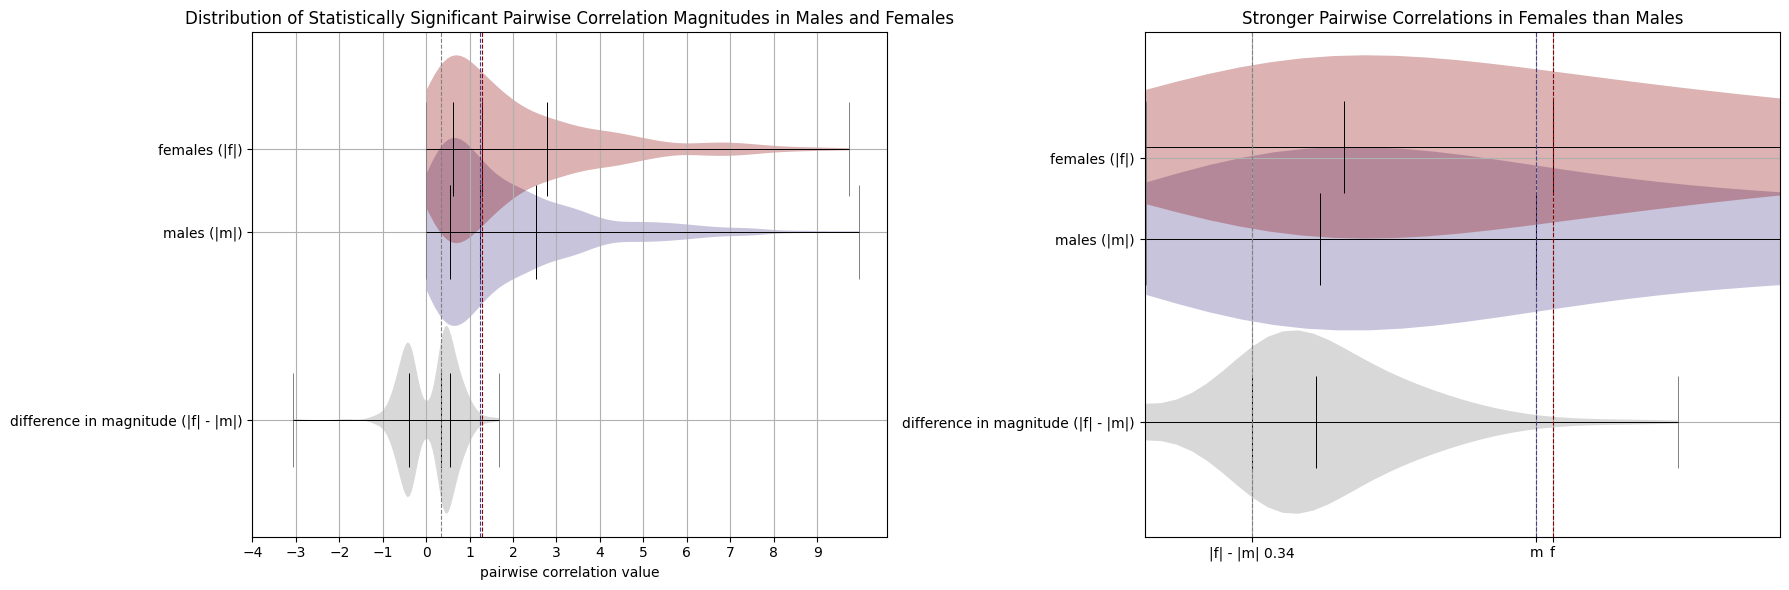

In [180]:
max_cmap = 'gist_earth_r'

# significant region heatmap
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # creates subplots
m_sig_vmin, m_sig_vmax = get_minmax(m_sig_corr) # thresholds colormap
f_sig_vmin, f_sig_vmax = get_minmax(f_sig_corr)
diff_sig_vmin, diff_sig_vmax = get_minmax(f_sig_corr - m_sig_corr)
plotting.plot_matrix( # visualize element-wise difference of averages
    set_upper_triangular(m_significant_regions), colorbar=True, vmax=m_sig_vmax, vmin=m_sig_vmin, axes=axes[1], title = "Statistically Significant Pairwise Correlations (M, $\\alpha$)", cmap=cmap)
plotting.plot_matrix( # visualize element-wise difference of averages
    set_upper_triangular(f_significant_regions), colorbar=True, vmax=f_sig_vmax, vmin=f_sig_vmin, axes=axes[0], title = "Statistically Significant Pairwise Correlations (F, $\\alpha$)", cmap=cmap)
plotting.plot_matrix( # visualize element-wise difference of averages
    set_upper_triangular(f_significant_regions - m_significant_regions), colorbar=True, vmax=diff_sig_vmax, vmin=diff_sig_vmin, axes=axes[2], title = "The Difference (F-M, $\\alpha$)", cmap=bicmap)
plt.tight_layout()

# bonferroni significant region heatmap
fig, axes = plt.subplots(1, 3, figsize=(24, 6)) # creates subplots
m_sig_bon_vmin, m_sig_bon_vmax = get_minmax(m_sig_corr_bonferroni) # thresholds colormp
f_sig_bon_vmin, f_sig_bon_vmax = get_minmax(f_sig_corr_bonferroni)
diff_sig_b_vmin, diff_sig_b_vmax = get_minmax(f_sig_corr_bonferroni - m_sig_corr_bonferroni)
plotting.plot_matrix( # visualize element-wise difference of averages
    set_upper_triangular(m_significant_regions_bonferroni), colorbar=True, vmax=m_sig_bon_vmax, vmin=m_sig_bon_vmin, axes=axes[1], title = "Statistically Significant Pairwise Correlations (M, $\\alpha_{\\text{bonferroni}}$)", cmap=cmap)
plotting.plot_matrix( # visualize element-wise difference of averages
    set_upper_triangular(f_significant_regions_bonferroni), colorbar=True, vmax=f_sig_bon_vmax, vmin=f_sig_bon_vmin, axes=axes[0], title = "Statistically Significant Pairwise Correlations (F, $\\alpha_{\\text{bonferroni}}$)", cmap=cmap)
plotting.plot_matrix( # visualize element-wise difference of averages
    set_upper_triangular(np.abs(f_significant_regions_bonferroni - m_significant_regions_bonferroni)), colorbar=True, vmax=diff_sig_b_vmax, vmin=diff_sig_b_vmin, axes=axes[2], title = "The Difference (F-M, $\\alpha_{\\text{bonferroni}}$)", cmap=bicmap)
plt.tight_layout()

# violin plot of magnitudes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
positions = [1, 1.50, 1.72]
def set_axis_style(ax, labels):
    ax.set_yticks(positions, labels=labels)
# LEFT ->
data = [np.abs(f_sig_corr_bonferroni) - np.abs(m_sig_corr_bonferroni),  np.abs(m_sig_corr_bonferroni), np.abs(f_sig_corr_bonferroni)] #bottom, middle, top
vplot1 = ax1.violinplot(
    dataset=data, 
    vert=False, 
    showmeans=False, 
    showmedians=True, 
    widths=0.5, 
    quantiles=[[0.25, 0.50, 0.75], [0.25, 0.50, 0.75], [0.25, 0.50, 0.75]], 
    positions=positions
) 
# medians
f_median = np.median(np.abs(f_sig_corr_bonferroni))
m_median = np.median(np.abs(m_sig_corr_bonferroni))
diff_median = np.median(np.abs(f_sig_corr_bonferroni) - np.abs(m_sig_corr_bonferroni))
ax1.axvline(m_median, lw=0.8, linestyle='--', color=m_color)
ax1.axvline(f_median, lw=0.8, linestyle='--', color=f_color)
ax1.axvline(diff_median, lw=0.8, linestyle='--', color='grey')
ax1.set_xticks(np.arange(-4, 10, 1))
ax1.set_xlabel('pairwise correlation value')
ax1.set_title('Distribution of Statistically Significant Pairwise Correlation Magnitudes in Males and Females')
ax1.grid(True)
# RIGHT ->
data = [np.abs(f_sig_corr_bonferroni) - np.abs(m_sig_corr_bonferroni),  np.abs(m_sig_corr_bonferroni), np.abs(f_sig_corr_bonferroni)]
vplot2 = ax2.violinplot(dataset=data, vert=False, showmeans=False, showmedians=True, widths=0.5, quantiles=[[0.25, 0.50, 0.75], [0.25, 0.50, 0.75], [0.25, 0.50, 0.75]], positions=[1, 1.50, 1.75])  # Adjust width here
# medians
ax2.set_title('Stronger Pairwise Correlations in Females than Males')
ax2.set_xlim(0, 2)
ax2.axvline(m_median, lw=0.8, linestyle='--', color=m_color)
ax2.axvline(f_median, lw=0.8, linestyle='--', color=f_color)
ax2.axvline(diff_median, lw=0.8, linestyle='--', color='grey')
ax2.grid(True)
# y-axis
ax2.set_xticks([m_median, f_median, diff_median], ['m', 'f', f'|f| - |m| {np.round(diff_median, 2)}'])
# COLOR CODING ->
colors = ['grey', m_color, f_color]
for vplot in (vplot1, vplot2): # left and right subplots
    vplot['cquantiles'].set_edgecolor('black')
    vplot['cquantiles'].set_linewidth(0.7)

    vplot['cbars'].set_edgecolor('black')
    vplot['cbars'].set_linewidth(0.7)

    vplot['cmins'].set_edgecolor('grey')
    vplot['cmins'].set_linewidth(0.7)

    vplot['cmaxes'].set_edgecolor('grey')
    vplot['cmaxes'].set_linewidth(0.7)
    
    vplot['cmedians'].set_edgecolor('black')
    vplot['cmedians'].set_linewidth(0.7)

    for patch, color in zip(vplot['bodies'], colors): # individual violin plots
        patch.set_facecolor(color)
# LABELS ->
labels = ['difference in magnitude (|f| - |m|)', 'males (|m|)', 'females (|f|)']
for ax in [ax1, ax2]:
    set_axis_style(ax, labels) # y-axis

plt.tight_layout()
plt.show()


In [182]:
print(f"The 50th percentile of the strength in pairwise correlations for females is {f_median - m_median} greater than that for males.")

The 50th percentile of the strength in pairwise correlations for females is 0.0519262152556621 greater than that for males.
